# Challenge 3: Artificial Neural Networks

<a target="_blank" href="https://colab.research.google.com/github/LucaPennella/Intro_to_ML_23-24/blob/main/challenges/challenge-three.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


Using Fully Connected Neural Networks and Convolutional Neural Networks, perform the following tasks on [this data set](https://pytorch.org/vision/stable/generated/torchvision.datasets.KMNIST.html#torchvision.datasets.KMNIST).
1. Data exploration.
2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.
3. Summarise your results in a table and comment on them in the report.
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from time import time

torch.manual_seed(0)

## Data exploration

In [2]:
BATCH_SIZE = 64

data_transforms = transforms.ToTensor()

# TRAIN set
trainset = torchvision.datasets.KMNIST(root='./data', train=True, download=True, transform=data_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
print(len(trainset))

# TEST set
testset = torchvision.datasets.KMNIST(root='./data', train=False, download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
print(len(testset))

60000
10000


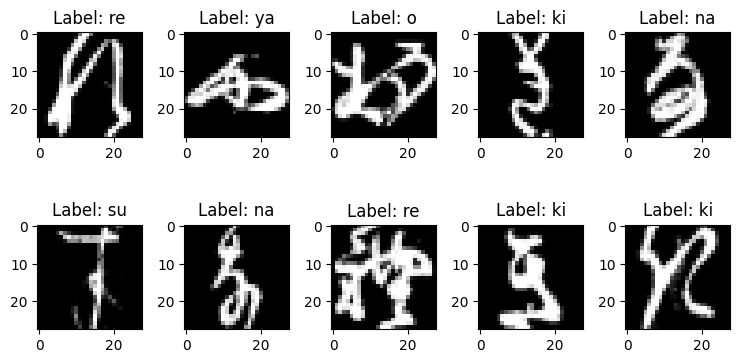

Classes: ['o', 'ki', 'su', 'tsu', 'na', 'ha', 'ma', 'ya', 're', 'wo']


In [3]:
num_row = 2
num_col = 5

classes = trainset.classes

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col, 2*num_row))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(trainset.data[i], cmap='gray')
    ax.set_title('Label: {}'.format(classes[trainset.targets[i]]))
plt.tight_layout()
plt.show()

print(f'Classes: {classes}')

In [4]:
# printing data shapes
print("Single image dimensions:", trainset.data[0].shape)
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Single image dimensions: torch.Size([28, 28])
Image batch dimensions: torch.Size([64, 1, 28, 28])
Image label dimensions: torch.Size([64])


The data comes from the KMNIST dataset and it consists of consists of 70000 28x28 pixel, 1 channel images of hiragana symbols; 60000 are reserved for the training set and 10000 for the test set. The symbols are grouped in 10 classes

## Model building

2. For each architecture, tune the number of the hidden layers ($\le 3$), the optimizer, and some hyperparameters of your choice. How many tries to do is up to your discretion.

We chose to implement three models: a FCNN with 1 hidden layer, a CNN with 1 hidden layer, and a CNN with 3 hidden layers.

#### FULLY CONNECTED

In [5]:
class FullyConnected_1(nn.Module):
    
    def __init__(self):
        super(FullyConnected_1, self).__init__()

        self.l1 = nn.Linear(28 * 28, 32 * 26 * 26)  # Input size: 28*28
        self.l2 = nn.Linear(32 * 26 * 26, 128)
        self.l3 = nn.Linear(128, 10)


    def forward(self, x):
        
        x = x.flatten(start_dim = 1)    # flatten: BSx1x28x28 => BSx784      

        x = self.l1(x)                  # Linear: BSx784 => BSx21632
        x = F.relu(x)

        x = self.l2(x)                  # Linear: BSx21632 => BSx128
        x = F.relu(x)

        logits = self.l3(x)             # Linear: BSx128 => BSx10

        out = F.softmax(logits, dim=1)  # Softmax computation

        return out

#### CONVOLUTIONAL

1 hidden layer

In [6]:
class Convolutional_1(nn.Module):
    
    def __init__(self):
        super(Convolutional_1, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)   # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.l1 = nn.Linear(32 * 12 * 12, 128)
        self.l2 = nn.Linear(128, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = x.flatten(start_dim = 1)    # flatten => BS x 4608

        x = self.l1(x)                  # Linear: BSx(32*12*12) => BSx128
        x = F.relu(x)

        logits = self.l2(x)             # Linear: BSx128 => BSx10

        out = F.softmax(logits, dim=1)  # Softmax computation

        return out

3 hidden layers

In [7]:
class Convolutional_3(nn.Module):
    
    def __init__(self):
        super(Convolutional_3, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5)       # 28 - kernel_size +1 = 24
        # max-pooling 2x2: 24 / 2 = 12
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=128, kernel_size=3)     # 12 - kernel_size +1 = 10
        # max-pooling 2x2: 10 / 2 = 5
        self.l1 = nn.Linear(128 * 5 * 5, 256)
        self.l2 = nn.Linear(256, 64)
        self.l3 = nn.Linear(64, 10)


    def forward(self, x):

        x = self.conv1(x)               # Convolution: BSx1x28x28 => BSx32x24x24
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx32x12x12

        x = self.conv2(x)               # Convolution: BSx32x12x12 => BSx128x10x10
        x = F.relu(x)

        x = F.max_pool2d(x,2)           # Max-pooling 2x2 => BSx128x5x5

        x = x.flatten(start_dim = 1)    # flatten => BS x 3200

        x = self.l1(x)                  # Linear: BSx(128*5*5) => BSx256
        x = F.relu(x)

        x = self.l2(x)                  # Linear: BSx256 => BSx64
        x = F.relu(x)

        logits = self.l3(x)             # Linear: BSx64 => BSx10

        out = F.softmax(logits, dim=1)  # Softmax computation

        return out

#### Training cycle

In [8]:
def get_accuracy(logit, target):
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()   # correct predictions
    accuracy = 100.0 * corrects / target.size(0)                                        # % of correct predictions
    return accuracy.item()


def compute_weight_norm(model):     # extracting the weight norms
    norm = 0.0
    for name, param in model.named_parameters():
        if "weight" in name:
            norm += torch.norm(param.data, p=2)
    return norm.cpu().item()


def train_model(model, num_epochs, trainloader, criterion, optimizer, device):

    print(f'Training model: {model.__class__.__name__} with Loss function: {criterion} and Optimizer: {optimizer.__class__.__name__}\n')

    model = model.to(device)

    losses = []
    accs = []

    norms = []

    for epoch in range(num_epochs):
        train_running_loss = 0.0
        train_acc = 0.0

        # Set the model to training mode
        model = model.train()
        start = time()
        ## training step
        for i, (images, labels) in enumerate(trainloader):

            images = images.to(device)
            labels = labels.to(device)

            ## forward + backprop + loss
            logits = model(images)
            loss = criterion(logits, labels)

            # Reset the gradients to zero
            optimizer.zero_grad()

            loss.backward()

            ## update model params
            optimizer.step()

            train_running_loss += loss.item()
            train_acc += get_accuracy(logits, labels)


        losses.append(train_running_loss / i)
        accs.append(train_acc/i)

        norms.append(compute_weight_norm(model))
        model.eval()
        print(f"\tEpoch: [{epoch+1}/{num_epochs}] | Loss: {train_running_loss / i:.4f} | Train Accuracy: {train_acc/i:.4f} | Time: {time()-start:.2f}")

    print('\n')
    return losses, accs, norms

In [9]:
num_epochs = 10
num_models = 3*2    # 3 models, 2 optimizers
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]
criterion = nn.CrossEntropyLoss()

losses = []
accuracies = []
weight_norms = []
optimizer_names = ['SGD', 'Adam']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# We want to train our models with different learning rates
for lr in learning_rates:

    print('-'*90)
    print(f'Training with learning rate: {lr}')
    print(f'Using device: {device}' if device=='cpu' else f'Using device: {device} ({torch.cuda.get_device_name()})')
    print('-'*90)
    print()

    losses_lr = []
    accuracies_lr = []
    weight_norms_lr = []

    # Training each model-optimizer pair
    for model_index in range(0, num_models, 2):

        # re-initiliazing our models for every optimizer
        models = [FullyConnected_1(), FullyConnected_1(), Convolutional_1(), Convolutional_1(), Convolutional_3(), Convolutional_3()]

        loss_sgd, acc_sgd, W_sgd = train_model(models[model_index], num_epochs, trainloader, criterion, torch.optim.SGD(models[model_index].parameters(), lr=lr), device)
        loss_adam, acc_adam, W_adam = train_model(models[model_index+1], num_epochs, trainloader, criterion, torch.optim.Adam(models[model_index+1].parameters(), lr=lr), device)

        losses_lr.extend([loss_sgd, loss_adam])
        accuracies_lr.extend([acc_sgd, acc_adam])
        weight_norms_lr.extend([W_sgd, W_adam])

    losses.append(losses_lr)
    accuracies.append(accuracies_lr)
    weight_norms.append(weight_norms_lr)

    print()

------------------------------------------------------------------------------------------
Training with learning rate: 1e-05
Using device: cuda (AMD Radeon RX 7800 XT)
------------------------------------------------------------------------------------------

Training model: FullyConnected_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/10] | Loss: 2.3052 | Train Accuracy: 11.3861 | Time: 5.50
	Epoch: [2/10] | Loss: 2.3051 | Train Accuracy: 11.5345 | Time: 5.07
	Epoch: [3/10] | Loss: 2.3051 | Train Accuracy: 11.6879 | Time: 5.07
	Epoch: [4/10] | Loss: 2.3050 | Train Accuracy: 11.8246 | Time: 5.07
	Epoch: [5/10] | Loss: 2.3050 | Train Accuracy: 11.9914 | Time: 5.05
	Epoch: [6/10] | Loss: 2.3049 | Train Accuracy: 12.2232 | Time: 5.04
	Epoch: [7/10] | Loss: 2.3049 | Train Accuracy: 12.4333 | Time: 5.05
	Epoch: [8/10] | Loss: 2.3048 | Train Accuracy: 12.6684 | Time: 5.04
	Epoch: [9/10] | Loss: 2.3048 | Train Accuracy: 12.8702 | Time: 5.05
	Epoch: [10/10] | Loss: 2.

## Tables
3. Summarise your results in a table and comment on them in the report.

In [10]:
models_for_table = [[FullyConnected_1(), FullyConnected_1()], [Convolutional_1(), Convolutional_1()], [Convolutional_3(), Convolutional_3()]]
num_models = len(models_for_table)         # number of models: in this case, 3 (FullyConnected_1, Convolutional_1, Convolutional_3)
num_optimizers = len(optimizer_names)      # number of optimizers: in this case, 2 (SGD and Adam)
num_rows = num_epochs * num_models * num_optimizers

pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_rows', None)     # To display all rows

for lr_index, lr in enumerate(learning_rates):
    
    print(f'\nLearning rate: {lr}')

    table = pd.DataFrame({'Model' : [models_for_table[i][0].__class__.__name__ for i in range(num_models) for j in range(num_epochs*num_optimizers)],
            'Optimizer' : [optimizer_names[i] for k in range(num_models) for i in range(num_optimizers) for j in range(num_epochs)],
            'Epoch': [i % (num_epochs) + 1 for i in range(num_rows)],
            'Loss': [losses[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            'Accuracy (train)': [accuracies[lr_index][i][j] for i in range(num_models*num_optimizers) for j in range(num_epochs)],
            })

    separator = pd.DataFrame({'Model' : ['---'],
            'Optimizer' : ['---'],
            'Epoch': ['---'],
            'Loss': ['---'],
            'Accuracy (train)': ['---'],
            })

    for i in range(num_optimizers*num_epochs, num_rows, num_optimizers*num_epochs+1):
        table = pd.concat([table.iloc[:i], separator, table.iloc[i:]]).reset_index(drop=True)

    print(table)
    print('-'*64)


Learning rate: 1e-05
               Model Optimizer Epoch      Loss Accuracy (train)
0   FullyConnected_1       SGD     1  2.305154        11.386073
1   FullyConnected_1       SGD     2  2.305107        11.534485
2   FullyConnected_1       SGD     3   2.30506          11.6879
3   FullyConnected_1       SGD     4  2.305014         11.82464
4   FullyConnected_1       SGD     5  2.304966        11.991395
5   FullyConnected_1       SGD     6  2.304919        12.223186
6   FullyConnected_1       SGD     7  2.304873        12.433298
7   FullyConnected_1       SGD     8  2.304824        12.668423
8   FullyConnected_1       SGD     9  2.304777        12.870197
9   FullyConnected_1       SGD    10  2.304731        13.081977
10  FullyConnected_1      Adam     1  1.838012         72.09345
11  FullyConnected_1      Adam     2  1.679531        80.794757
12  FullyConnected_1      Adam     3  1.655332        82.447305
13  FullyConnected_1      Adam     4  1.641058        83.634605
14  FullyConnected

#### Table summary
- Learning rates >= 3 always produce bad results
- All models w/ Adam and lr >= 0.01 are stuck on accuracy 10
<br><br>
Here are some relevant cases with respect to training accuracy
- Adam w/ lr=0.001: Convolutional_3
- SGD w/ lr=0.5: Convolutional_1
- SGD w/ lr=1:   FullyConnected_1

- Adam w/ lr=0.0001: FullyConnected_1
- Adam w/ lr=0.001:  Convolutional_1


## Plotting
4. For a model (not necessarily the best performing one), plot training loss vs testing loss and training accuracy vs testing accuracy, and comment on what you see.

We chose to take a look at the Convolutional_1 model with learning rate = 0.5 and SGD optimizer

In [11]:
# Shared parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
learning_rate = 0.5
criterion = nn.CrossEntropyLoss() # loss function

*Plotting training results*

In [12]:
model = Convolutional_1()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

print(f'Learning rate: {learning_rate}')
loss, accuracies, W_default = train_model(model, num_epochs, trainloader, criterion, optimizer, device)

Learning rate: 0.5
Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/10] | Loss: 1.6937 | Train Accuracy: 77.5764 | Time: 4.40
	Epoch: [2/10] | Loss: 1.5654 | Train Accuracy: 90.2631 | Time: 4.37
	Epoch: [3/10] | Loss: 1.5384 | Train Accuracy: 92.7628 | Time: 4.35
	Epoch: [4/10] | Loss: 1.5290 | Train Accuracy: 93.5816 | Time: 4.37
	Epoch: [5/10] | Loss: 1.5082 | Train Accuracy: 95.7027 | Time: 4.40
	Epoch: [6/10] | Loss: 1.4941 | Train Accuracy: 97.1418 | Time: 4.35
	Epoch: [7/10] | Loss: 1.4901 | Train Accuracy: 97.4887 | Time: 4.33
	Epoch: [8/10] | Loss: 1.4877 | Train Accuracy: 97.7138 | Time: 4.37
	Epoch: [9/10] | Loss: 1.4861 | Train Accuracy: 97.8305 | Time: 4.38
	Epoch: [10/10] | Loss: 1.4849 | Train Accuracy: 97.9339 | Time: 4.38




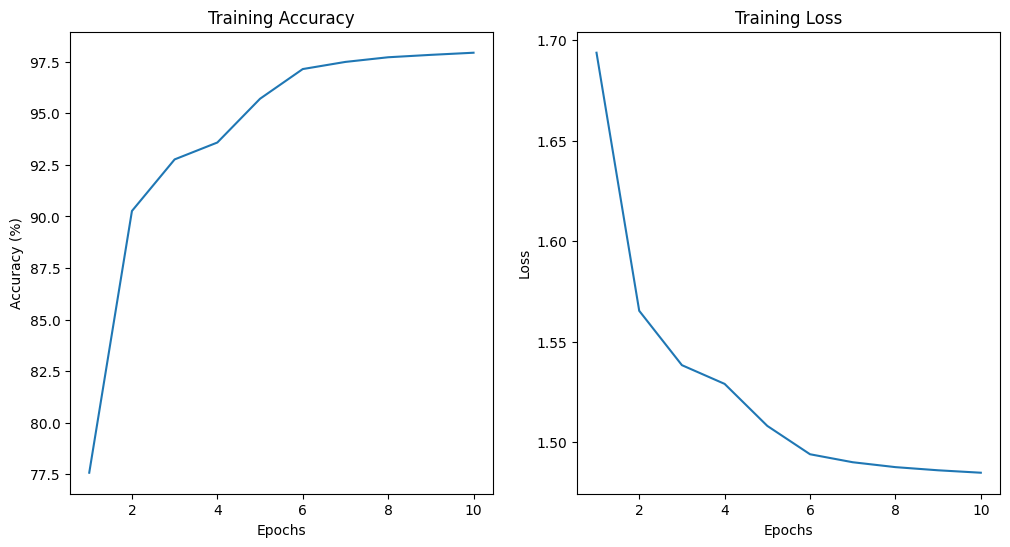

In [13]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(range(1, num_epochs+1), accuracies)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training Accuracy')

ax2.plot(range(1, num_epochs+1), loss)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss')

plt.show()

*Plotting testing results*

In [14]:
def test_model(model):

    test_running_acc = 0.0
    test_running_loss = 0.0
    test_accuracy = []
    test_loss = []

    for i, (images, labels) in enumerate(testloader, 0):

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        test_running_loss += loss.item()/(len(testloader) - 1)
        test_running_acc += get_accuracy(outputs, labels)/(len(testloader) - 1)

    test_accuracy += [test_running_acc]
    test_loss += [test_running_loss]

    print(f"Test Accuracy: {test_running_acc:.4f}")
    print(f"Test Loss: {test_running_loss:.4f}")

    return test_accuracy, test_loss

In [15]:
model = Convolutional_1()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

test_accuracy_list = []
test_loss_list = []

# This value sets the interval after which a test set evaluation is performed;
# for example, if epochs_interval = 2, the model is tested after every two training epochs
epochs_interval = 1

for i in range(int(num_epochs/epochs_interval)):

    loss, accuracies, W = train_model(model, epochs_interval, trainloader, criterion, optimizer, device)
    print(f'Total epochs: [{(i+1)*epochs_interval}/{num_epochs}]')

    test_accuracy, test_loss = test_model(model)
    test_accuracy_list.append(test_accuracy)
    test_loss_list.append(test_loss)
    
    print('-'*90)
    print()

Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/1] | Loss: 1.6920 | Train Accuracy: 77.6698 | Time: 4.36


Total epochs: [1/10]
Test Accuracy: 75.0000
Test Loss: 1.7329
------------------------------------------------------------------------------------------

Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/1] | Loss: 1.5588 | Train Accuracy: 90.8685 | Time: 4.38


Total epochs: [2/10]
Test Accuracy: 82.1214
Test Loss: 1.6590
------------------------------------------------------------------------------------------

Training model: Convolutional_1 with Loss function: CrossEntropyLoss() and Optimizer: SGD

	Epoch: [1/1] | Loss: 1.5362 | Train Accuracy: 92.9429 | Time: 4.36


Total epochs: [3/10]
Test Accuracy: 84.0144
Test Loss: 1.6388
------------------------------------------------------------------------------------------

Training model: Convolutional_1 with Loss function: Cro

In [16]:
print(test_accuracy_list)
print(test_loss_list)

[[75.00000000000004], [82.12139423076928], [84.01442307692307], [84.71554487179492], [91.4262820512821], [92.0272435897436], [93.16907051282053], [94.13060897435899], [94.35096153846149], [94.43108974358977]]
[[1.732901245355607], [1.6589891283940048], [1.6387685774228513], [1.6319000812677236], [1.5659554547224284], [1.559643380917036], [1.5473556594970888], [1.5379102581586594], [1.536184690701656], [1.5344238013793252]]


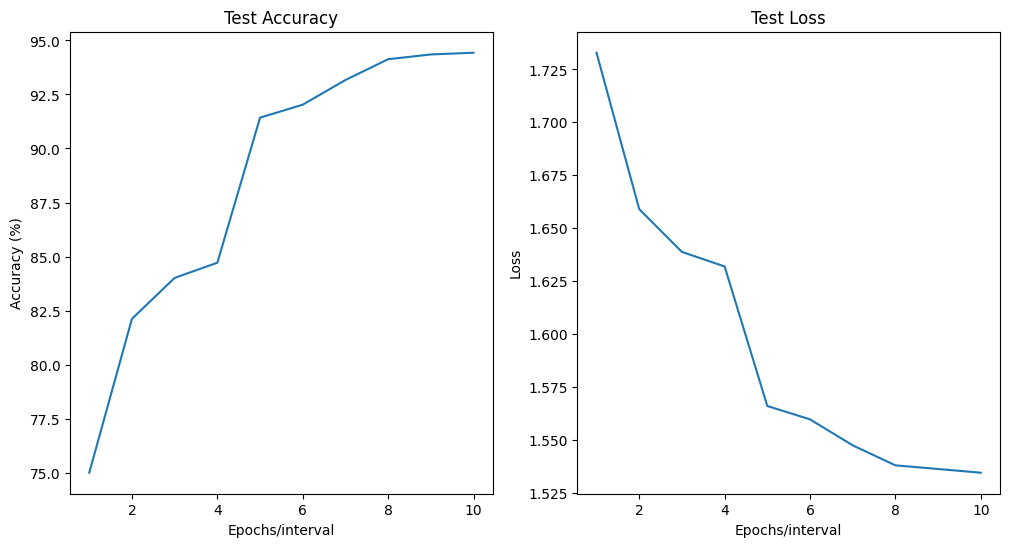

In [17]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6))
x_axis = len(test_accuracy_list)

ax1.plot(range(1, x_axis+1), test_accuracy_list)
ax1.set_xlabel('Epochs/interval')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Test Accuracy')

ax2.plot(range(1, x_axis+1), test_loss_list)
ax2.set_xlabel('Epochs/interval')
ax2.set_ylabel('Loss')
ax2.set_title('Test Loss')

plt.show()